# Cryptocurrency Classification Training
This notebook demonstrates a from-scratch training pipeline to predict bullish hours using engineered features.

## 1. Generate or load dataset

In [10]:
from pathlib import Path
from utils.build_dataset import generate_dataset

RAW_CSV = Path('data/raw/BTCUSDT_1h.csv')
OUTPUT_DIR = Path('data/processed/classification')
VERSION = 'v1'

# Generate dataset if it does not already exist
if not (OUTPUT_DIR / f'X_{VERSION}.parquet').exists():
    generate_dataset(
        raw_path=str(RAW_CSV),
        output_dir=str(OUTPUT_DIR),
        version=VERSION,
        task='classification',
        horizon=3,
        ml_logger=None,
    )


## 2. Load processed features and labels

In [11]:
import pandas as pd

base = Path('data/processed/classification')
X = pd.read_parquet(base / f'X_{VERSION}.parquet')
y = pd.read_parquet(base / f'y_{VERSION}.parquet').squeeze()

# Align indices and sort chronologically
X = X.sort_index()
y = y.loc[X.index]


## 3. Train/test split

In [12]:
import numpy as np

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, X_val, X_test = np.split(X, [train_size, train_size + val_size])
y_train, y_val, y_test = np.split(y, [train_size, train_size + val_size])


## 4. Hyperparameter search

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    precision_recall_curve, roc_curve, roc_auc_score, accuracy_score, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# === Scaling ===
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

# === Train Model ===
X_all = np.vstack([X_train_s, X_val_s])
y_all = pd.concat([y_train, y_val])

clf = XGBClassifier(n_estimators=300, max_depth=4, learning_rate=0.05, random_state=42, tree_method='gpu_hist', predictor='gpu_predictor')
clf.fit(X_all, y_all)

# === Predict Probabilities ===
y_proba = clf.predict_proba(X_test_s)[:, 1]

# === Threshold Optimization ===
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_f1_thresh = thresholds[np.argmax(f1s)]

returns = y_proba - 0.5  # Mock profit proxy
pnl = [np.sum((y_proba > t) * returns) for t in thresholds]
best_pnl_thresh = thresholds[np.argmax(pnl)]

# === Evaluation (Train / Val / Test) ===
y_train_proba = clf.predict_proba(X_train_s)[:, 1]
y_val_proba = clf.predict_proba(X_val_s)[:, 1]

y_train_pred = (y_train_proba > best_f1_thresh).astype(int)
y_val_pred = (y_val_proba > best_f1_thresh).astype(int)
y_test_pred = (y_proba > best_f1_thresh).astype(int)

# === Compute Accuracy Scores ===
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# === Compute Confusion Matrix and ROC ===
cm = confusion_matrix(y_test, y_test_pred)
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

## 5. Evaluate model

In [14]:
from sklearn.metrics import classification_report

print(f"\n🔍 Evaluation Summary (Threshold = {best_f1_thresh:.3f})\n")
print(f"📊 Train Accuracy     : {train_acc:.4f}")
print(f"📊 Validation Accuracy: {val_acc:.4f}")
print(f"📊 Test Accuracy      : {test_acc:.4f}")
print(f"🎯 ROC AUC (Test)      : {auc_score:.4f}\n")

print("📄 Test Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))
print("🧮 Confusion Matrix (Test):")
print(cm)
print("-" * 70)


🔍 Evaluation Summary (Threshold = 0.272)

📊 Train Accuracy     : 0.5890
📊 Validation Accuracy: 0.5591
📊 Test Accuracy      : 0.5620
🎯 ROC AUC (Test)      : 0.6808

📄 Test Classification Report:
              precision    recall  f1-score   support

         0.0     0.9417    0.2919    0.4457      6145
         1.0     0.4746    0.9725    0.6379      4042

    accuracy                         0.5620     10187
   macro avg     0.7082    0.6322    0.5418     10187
weighted avg     0.7564    0.5620    0.5220     10187

🧮 Confusion Matrix (Test):
[[1794 4351]
 [ 111 3931]]
----------------------------------------------------------------------


## 6. Plot model evaluation

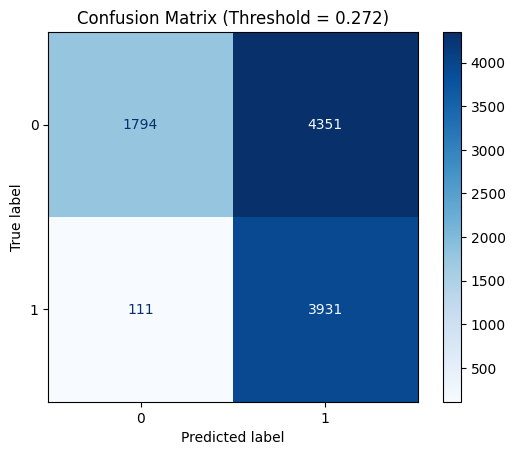

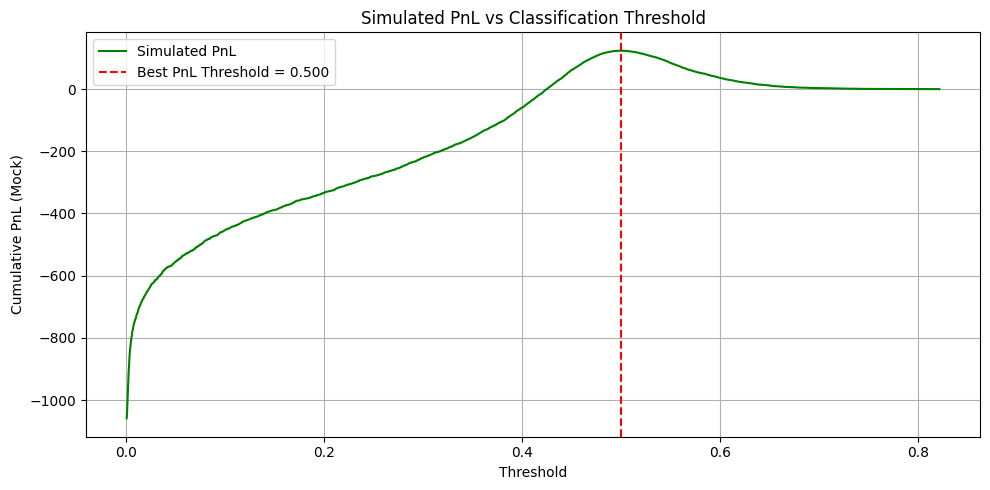

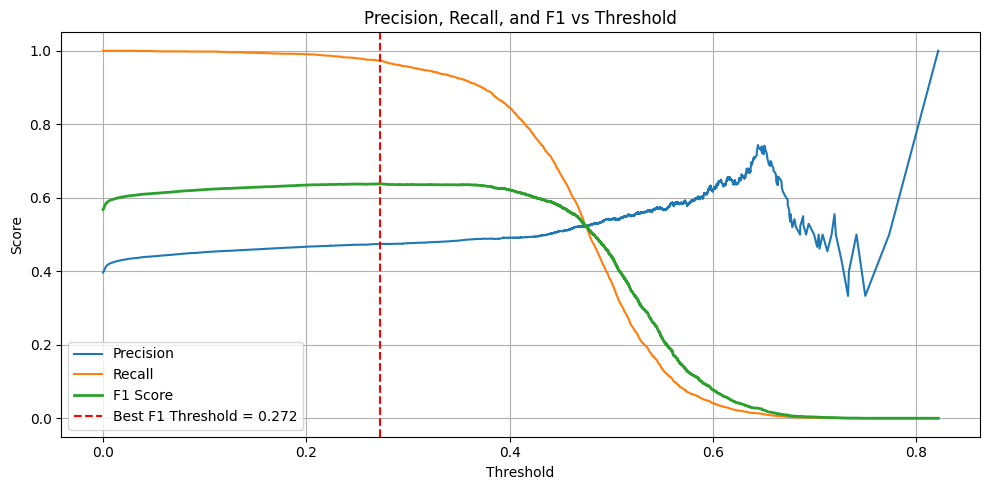

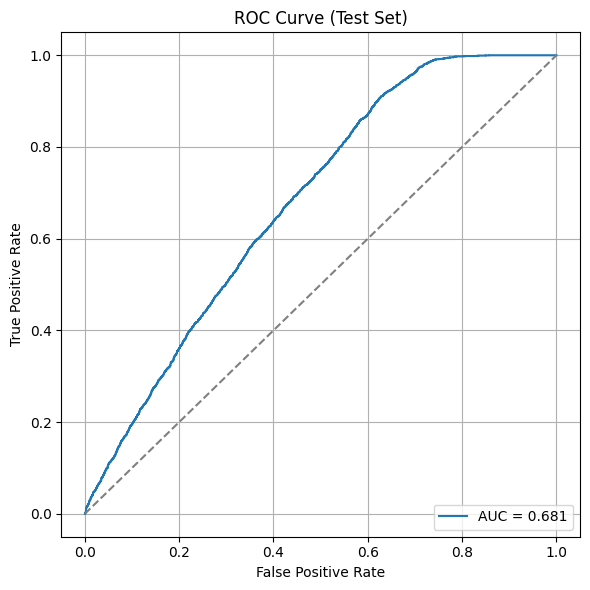

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# === PLOT 1: Confusion Matrix ===
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (Threshold = {best_f1_thresh:.3f})")
plt.grid(False)
plt.show()

# === PLOT 2: Simulated PnL vs Threshold ===
plt.figure(figsize=(10, 5))
plt.plot(thresholds, pnl, color="green", label="Simulated PnL")
plt.axvline(best_pnl_thresh, color='red', linestyle='--', label=f'Best PnL Threshold = {best_pnl_thresh:.3f}')
plt.title("Simulated PnL vs Classification Threshold")
plt.xlabel("Threshold")
plt.ylabel("Cumulative PnL (Mock)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === PLOT 3: Precision / Recall / F1 Score ===
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, f1s[:-1], label="F1 Score", linewidth=2)
plt.axvline(best_f1_thresh, color='red', linestyle='--', label=f'Best F1 Threshold = {best_f1_thresh:.3f}')
plt.title("Precision, Recall, and F1 vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === PLOT 4: ROC Curve ===
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. Save models

In [17]:
import joblib
from pathlib import Path

MODEL_DIR = Path("models/classification")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

bundle = {
    "model": clf,
    "scaler": scaler,
    "best_f1_thresh": best_f1_thresh,
    "best_pnl_thresh": best_pnl_thresh,
    "features": list(X.columns)
}
joblib.dump(bundle, MODEL_DIR / f"bundle_{VERSION}.joblib")


['models\\classification\\bundle_v1.joblib']